# Assessing the Likelihood of Contracting Heart Disease Based on 6 Health Factors

## 1. Introduction

### Inference Question:
How is the likelihood of contracting heart disease is impacted by 6 different health factors?

### The Heart Disease Dataset
The dataset that we will be using for this project is one related to heart disease and the factors that contribute towards it. Different factors such as blood pressure, cholesterol and even age can have great impacts on the risk of contracting heart disease and so this data set provides past details of patients with attributes they had and whether or not they were healthy or not. The link to this dataset is included below, but in this project we will be reading the data directly from the web, and so there is no need to have the file saved locally.

https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/

From the above link, the data from the Cleveland dataset will be used. The original dataset contains 76 factors, however, the processed data, which is what will be used in our project, contains 14 factors. We will further filter this data to be the 6 factors that we will be examining, which are listed below.

#### The Health Factors We Are Focusing On:
- age -> the age of the patient
- sex -> the sex of the patient
- pain.type -> the type of pain experienced by the patient (angina [1], abnormal angina [2], not angina [3], or asymptomatic [4])
- restbps -> the resting blood pressure of the patient
- cholesterol -> the cholesterol level of the patient
- maxbpm -> the maximum heart rate of the patient

We have chosen these specific factors for our analysis, as these are the factors we think would have the greatest influence on whether or not a patient potentially has heart disease. We also think that that heart disease would affect the women more than the men, and thus have included the sex variable, to see if this hypothesis holds true. 

The factors that were omitted, were a boolean value of fasting blood sugar being less than 120, resting ecg, a boolean to determine if the angina was exercise induced, oldpeak, slope, number of vessels coloured, and thalassemia. Some of these predictors were excluded due to their uncertain nature, in terms of measurement units and missing data, such as the number of vessels coloured. One debatable predictor is the resting ecg, which measures the electrical activity in the heart, however we deemed that the resting blood pressure would be a better indicator of heart activity and decided to use that instead.
______________________________________________________________________________________________________________________________________________________

## 2. Wrangling the Data

#### Loading Tidyverse
First we need to load the tidyverse library into R so that it is possible to wrangle the data and only select the factors that we will be making use of in this project.

In [29]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

#### Reading and Selecting the Data
We can make use of the `read_csv` function to extract the data from the web, and since there are no column names in the dataset, we will have to set `col_names = FALSE` and make a vector with the desired column names.

The dataset also classifies sick patients in three different categories, however for this analysis we will consider all of them as one category, and so we set the `health` column's values 2, 3, and 4, to 1 which signifies contracted-heart-disease, while 0 signifies a healthy patient. This allows us to more easily categorise whether or not the patient contracts a heart disease, regardless of the severity.

In [30]:
heart_data<- read_csv(url("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"), col_names = FALSE) |>
    select(X1, X2, X3, X4, X5, X8, X14)
colnames(heart_data) <- make.names(c("age", "sex", "pain.type", "restbps", "cholesterol", "maxbpm", "health"))

heart_data["health"][heart_data["health"] == 2 | heart_data["health"] == 3 | heart_data["health"] == 4] <- 1
heart_data

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,pain.type,restbps,cholesterol,maxbpm,health
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
63,1,1,145,233,150,0
67,1,4,160,286,108,1
67,1,4,120,229,129,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,115,1
57,0,2,130,236,174,1
38,1,3,138,175,173,0


To more clearly see why we've decided to group all the sick patients together, we have created a table below to show how the data is split, and that if there were 4 different categories of sickness it would create unnecessary confusion and problems.

In [31]:
health_freq <- table(heart_data$health)
rownames(health_freq) = c("Healthy", "Sick")
"# of Patients with and without Heart Disease"
health_freq

[1] "# of Patients with and without Heart Disease"


Healthy    Sick 
    164     139 

______________________________________________________________________________________________________________________________________________________

## 3. Analysis of Data

### 3.1 Splitting the Dataset into Training and Testing Data
We have chosen to select 75% of the data to be in the training data, while the other 25% will be used as testing data later on. We have also selected a seed to use, so that the results are reproducible in the future.

In [32]:
set.seed(1234)

heart_data_split <- initial_split(heart_data, prop = 0.75, strata = health)
heart_data_training <- training(heart_data_split)

### 3.2 Age and Heart Disease
To initially get a grasp on the dataset itself and what we will be conducting an analysis on, we have decided to plot a histogram showing the differing ages, and at what age/age range is a patient most likely to develop a heart disease.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



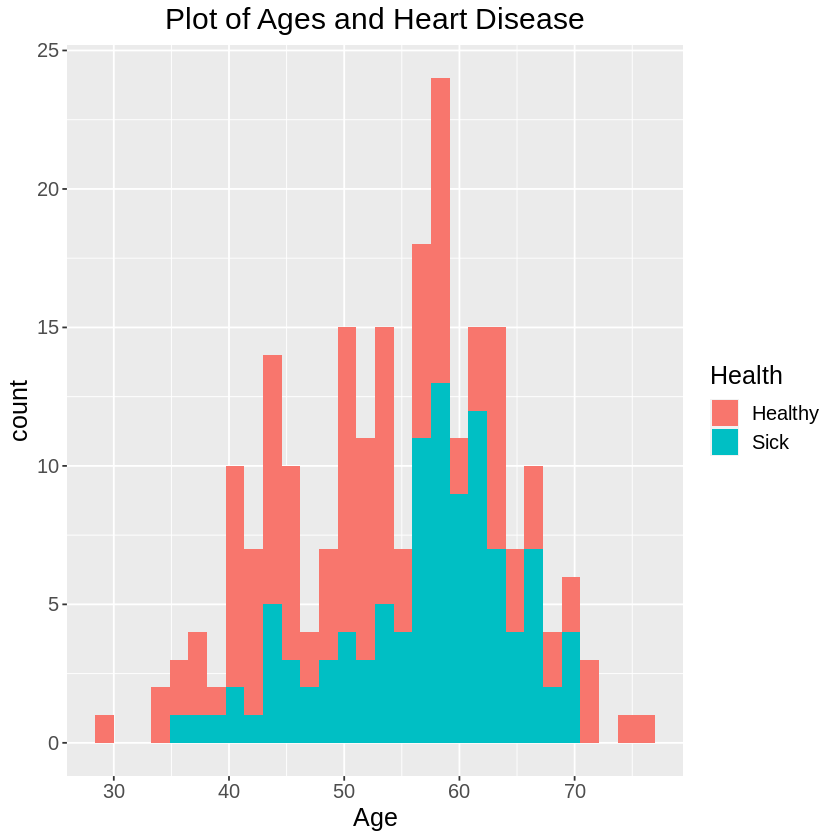

In [33]:
ages_and_heart_disease_plot <- heart_data_training |>
    ggplot(aes(x = age, fill = as_factor(health))) +
    geom_histogram() +
    labs(title = "Plot of Ages and Heart Disease", x = "Age", fill = "Health") +
    scale_fill_discrete(labels = c("Healthy", "Sick")) +
    theme(text = element_text(size = 15), plot.title = element_text(hjust = 0.5))
ages_and_heart_disease_plot

This plot provides a good visualisation of the dataset, and it shows with the differently coloured plots, we are able to see that the at-risk age range to contract heart disease seems to be around 60 years old. It is noted that although this age is where the number of sick patients peaks, it is also seent that a larger percentage of the population at this age, is healthy.

### 3.3 Chest Pain and Heart Disease
The first correlation we would like to explore is that between chest pain and heart disease. To visualise this, we will make use of a histogram, as well as a facet grid that encompasses the 4 different type of chest pains that were recorded in this dataset, that will essentially split the plot above into 4 different plots. To refresh, these chest pain types are angina [1], abnormal angina [2], not angina [3], or asymptomatic [4]. We will then colour the bars of the historgam to signify which patients were healthy and which contracted a heart disease.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



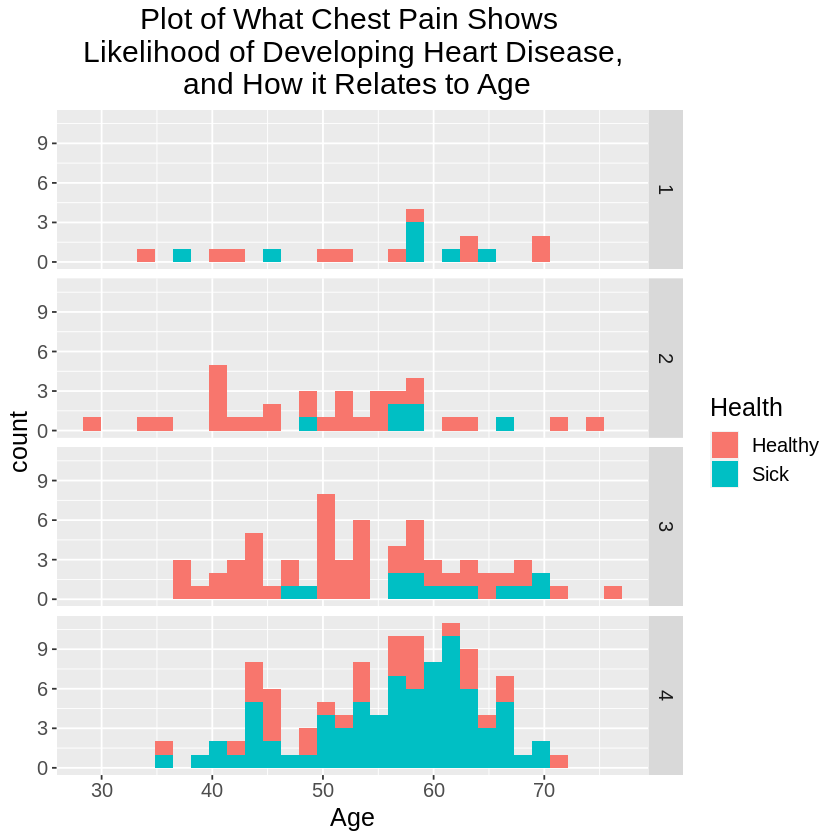

In [34]:
likelihood_of_heart_disease_plot <- heart_data_training |>
    ggplot(aes(x = age, fill = as_factor(health))) +
    geom_histogram() +
    facet_grid(rows = vars(pain.type)) +
    labs(title = "Plot of What Chest Pain Shows \n Likelihood of Developing Heart Disease, \n and How it Relates to Age", x = "Age", fill = "Health") +
    scale_fill_discrete(labels = c("Healthy", "Sick")) +
    theme(text = element_text(size = 15), plot.title = element_text(hjust = 0.5))

likelihood_of_heart_disease_plot

From the visualisation above, it is clear to see that the vast majority of patients in general are in category 4, which is asymptomatic. Additionally this is where the largest proportion of the sick population is as well, and it is illustrated that with the other types of chest pain, the ratio of healthy to sick is uneven, with there being more healthy patients than not. From this plot we can hypothesise that although chest pain could potentially be an indicator of contracting a heart disease, it is more likely that it is it's own issue, unrelated to heart disease.

### 3.4 Max Heart Rate and Heart Disease
Next we'd like to see how heart rate changes with age and if there is an clear, visible relationship between that and the likelihood of contratcing a heart disease. To visualise this, we will plot the data on a scatterplot, with age on the x-axis and max heart rate on the y-axis, and just like the previous plots, colour the points based on whether the patients were sick or healthy.

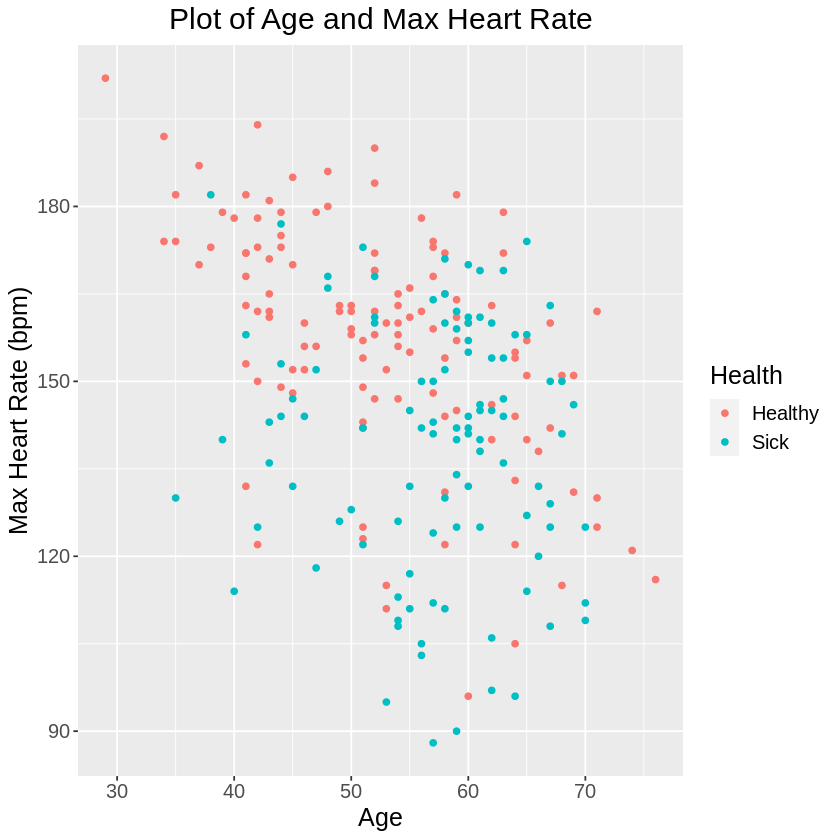

In [35]:
age_and_max_heart_rate_plot <- heart_data_training |>
    ggplot(aes(x = age, y = maxbpm, colour = as_factor(health))) +
    geom_point() +
    labs(title = "Plot of Age and Max Heart Rate", x = "Age", y = "Max Heart Rate (bpm)", colour = "Health") +
    scale_colour_discrete(labels = c("Healthy", "Sick")) +
    theme(text = element_text(size = 15), plot.title = element_text(hjust = 0.5))
age_and_max_heart_rate_plot

From the diagram above, the expected downward trend of the points is seen, as with increasing age, the peak heart rate will decrease. However we can also see that the bulk of the healthy patients are ones with a higher max heart rate, while the sick patients seem to have a lower average max heart rate. This suggests a correlation between this variable and the likelihood to develop heart disease.

### 3.5 Cholesterol and Heart Disease
Finally the last relationship we want to see visualised before conducting the rest of our analysis, is one between cholesterol levels in the patient and them contracting heart disease. This plot will also be in the form of a scatter plot, with age once again on the x-axis and cholesterol on the y-axis.

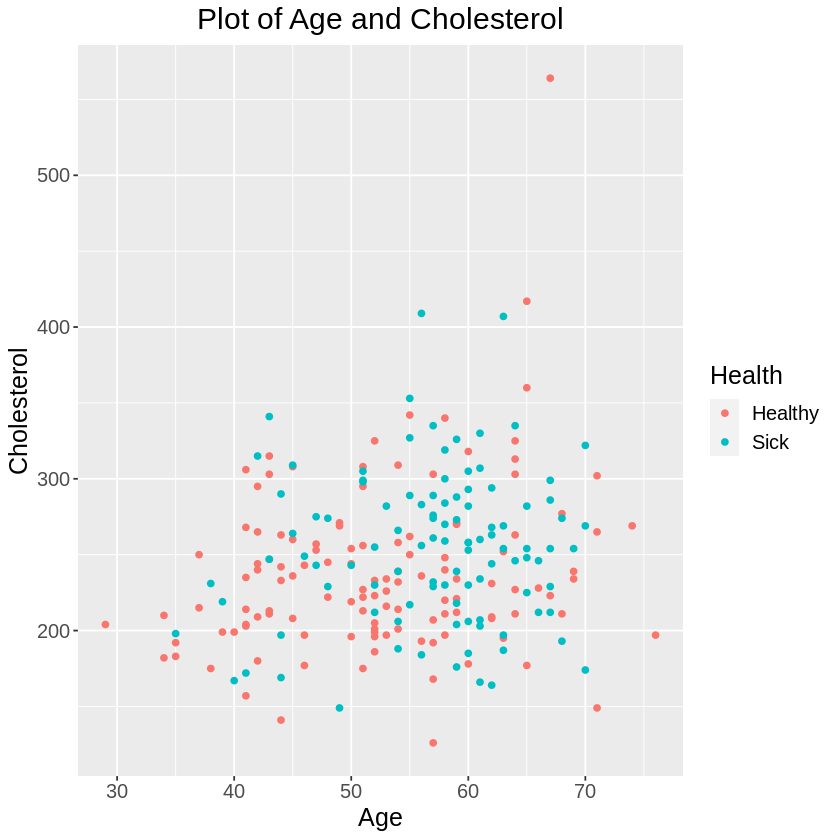

In [37]:
age_and_cholesterol_plot <- heart_data_training |>
    ggplot(aes(x = age, y = cholesterol, colour = as_factor(health))) +
    geom_point() +
    labs(title = "Plot of Age and Cholesterol", x = "Age", y = "Cholesterol", colour = "Health") +
    scale_colour_discrete(labels = c("Healthy", "Sick")) +
    theme(text = element_text(size = 15), plot.title = element_text(hjust = 0.5))
age_and_cholesterol_plot

From this plot, there is a very slight upward trend in the cholesterol levels in the patient, and this shows that as the age of the patients increases, it is typical for the cholesterol levels to increase slightly too, with some outliers. However, there seems to be little to no correlation between the cholesterol and the patient contracting heart disease, with the majority of the sick patients having slightly higher cholesterol levels. Although, as mentioned before this could also be in relation to the increasing age.
______________________________________________________________________________________________________________________________________________________

## 4. KNN Classification

[PLACEHOLDER] EXPLAIN WHAT WE WILL BE DOING